# DNN POUR CONTEXTE D'UN CYCLE D'INTERACTION

Tentive encore infructueuse

# On crée le modèle

Exemple: une couche de 10 neurones et une couche de 5 :

In [470]:
hidden_size = [10, 5]

In [471]:
# Importe le modèle préparé par PE
from model.DeepNN import DeepNetwork

# Entrée: 3 previous_action, previous_outcome, action 
# Sortie: 2 probabilités (une pour chaque outcome)
model_ML = DeepNetwork(hidden_size=hidden_size, input_size=3, output_size=2)
model_ML.to("cpu")

liste hidden init [10, 5]


DeepNetwork(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=10, out_features=5, bias=True)
  )
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)

# On tokenize le vocabulaire

In [472]:
# Import le tokenizer préparé par PE
from model.Tokenizer import SimpleTokenizerV1
from outil import create_dico_numerate_word

# Notre vocabulaire:
all_word = create_dico_numerate_word(['x', 'y', 'a', 'b'])
# Voici all_word : {'x': 0, 'y': 1, 'a': 2, 'b': 3}
print("Vocabulaire:", all_word)
# Nous n'avons pas besoin d'un tokenzier complexe, 
# il va avoir le même rôle qu'un dictionnaire
tokenizer = SimpleTokenizerV1(all_word)
# Maintenant pour encoder une action ou un outcome nous pouvons faire :
print('Test encode a:', tokenizer.encode('a'))
# et pour decoder :
print('Test decode 1:', tokenizer.decode(1))

Vocabulaire: {'x': 0, 'y': 1, 'a': 2, 'b': 3}
Test encode a: 2
Test decode 1: y


# On définit les paramètres du modèle

Le `lr` et le `weight_decay` sont des paramètres très importants qui vont permettre de corriger plus ou moins vite le modèle. Une correction rapide est moins précise.


In [473]:
lr = 1e-1
weight_decay = 1e-2

In [474]:
# On importe les outils fournis par torch
import torch
import torch.nn as nn

# Le modèle a besoin d'un optimizer pour corriger les poids.
optimizer = torch.optim.Adam(model_ML.parameters(), lr=lr, weight_decay=weight_decay)

# Nous avons aussi besoin d'une fonction de loss, par exemple la CrossEntropy
# Au vue de la simplicité de prédiction le type de loss importe peu
loss_func = nn.CrossEntropyLoss()

# La fonction fit() qui utilise train_with_batch()

In [475]:
# Importe la fonction train préparée par PE
from model.DeepNN import train_with_batch
from model.CustomLoader import CustomLoader

def fit1(actions, outcomes):
    actions = [[tokenizer.encode(act)] for act in actions]
    actions = torch.tensor(actions, dtype=torch.float).to("cpu") # On passe toutes les actions que l'agent a fais
    outcomes = tokenizer.encode(outcomes)
    outcomes = torch.tensor(outcomes, dtype=torch.long).to("cpu") # On passe toutes outcomes qu'il a recu
    data_loarder = CustomLoader(actions=actions, outcomes=outcomes, context_lenght=3)   
    data_loader = torch.utils.data.DataLoader(data_loarder, batch_size=32, shuffle=True)
    # On passe le modèle en mode train
    model_ML.train()
    # On appelle la fonction d'entrainement 
    train_with_batch(model_ML, 
            train_loader=data_loader,
            optimizer=optimizer,
            loss_func=loss_func,
            nb_epochs=1,
            validate_loader=None,
            print_=True)

In [498]:
fit1(['a', 'a'], ['x', 'y'])
fit1(['a', 'a'], ['y', 'y'])
fit1(['a', 'b'], ['x', 'x'])
fit1(['a', 'b'], ['y', 'x'])
fit1(['b', 'a'], ['x', 'x'])
fit1(['b', 'a'], ['y', 'x'])
fit1(['b', 'b'], ['x', 'y'])
fit1(['b', 'b'], ['y', 'y'])

Epoch 1/1, Loss: 0.7127
Epoch 1/1, Loss: 0.7007
Epoch 1/1, Loss: 0.7061
Epoch 1/1, Loss: 0.7149
Epoch 1/1, Loss: 0.7126
Epoch 1/1, Loss: 0.7006
Epoch 1/1, Loss: 0.7062
Epoch 1/1, Loss: 0.7149


La loss converge vers 0.7. Ca ne marche pas

# La fonction fit() qui utilise train()

In [499]:
# Importe la fonction train préparée par PE
from model.DeepNN import train

def fit(previous_action, previous_outcome, action, outcome):
    previous_action = tokenizer.encode(previous_action)
    previous_outcome = tokenizer.encode(previous_outcome)
    action = tokenizer.encode(action)
    input = torch.tensor([previous_action, previous_outcome, action], dtype=torch.float).to("cpu")
    outcome = tokenizer.encode(outcome)
    outcome = torch.tensor(outcome, dtype=torch.long).to("cpu")
    outcome = torch.nn.functional.one_hot(outcome, num_classes=2).to(torch.float)

    # On passe le modèle en mode train
    model_ML.train()
    # On appelle la fonction d'entrainement 
    train(model_ML, 
            train_data=[(input, outcome)],
            optimizer=optimizer,
            loss_func=loss_func,
            nb_epochs=1,
            validate_loader=None,
            print_=True)

On entraine le modèle dans en environnement ou l'agent doit alterner les actions `a` et `b` pour obtenir `x` sinon il obtient `y`.

Utiliser `Ctrl` + `Enter` pour l'exécuter plusieurs fois et voir la loss diminuer à chaque appel.

In [513]:
fit('a', 'x', 'a', 'y')
fit('a','y', 'a', 'y')
fit('a','x', 'b', 'x')
fit('a','y', 'b', 'x')
fit('b','x', 'a', 'x')
fit('b','y', 'a', 'x')
fit('b','x', 'b', 'y')
fit('b','y', 'b', 'y')

Epoch 1/1,, Loss: 0.7128
Epoch 1/1,, Loss: 0.7007
Epoch 1/1,, Loss: 0.7063
Epoch 1/1,, Loss: 0.7150
Epoch 1/1,, Loss: 0.7128
Epoch 1/1,, Loss: 0.7007
Epoch 1/1,, Loss: 0.7062
Epoch 1/1,, Loss: 0.7150


La loss converge vers 0.7. Ca ne marche pas

Visualisons les prédictions quand previous action est `a` et previous outcome `x` :

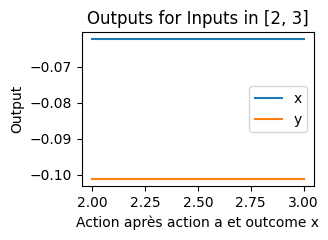

In [514]:
import matplotlib.pyplot as plt

# Generate inputs in the range [2, 3]
x1 = torch.full((100, 1), 2)  # previous action a
x2 = torch.full((100, 1), 0)  # previous outcome x
x3 = torch.linspace(2, 3, steps=100).unsqueeze(1)  # Shape (100,1)
inputs = torch.cat((x1, x2, x3), dim=1)

outputs = model_ML(inputs)

# Extract the first output value for each input
output_x = outputs[:, 0].detach().numpy()  # Detach and convert to NumPy
output_y = outputs[:, 1].detach().numpy()  # Detach and convert to NumPy

# Plot results
plt.figure(figsize=(3, 2))  # Reduce figure size by half
plt.plot(x3.numpy(), output_x, label="x")
plt.plot(x3.numpy(), output_y, label="y")
plt.xlabel("Action après action a et outcome x")
plt.ylabel("Output")
plt.title("Outputs for Inputs in [2, 3]")
plt.legend()
plt.show()

Il faut entrainer le modèle jusqu'a ce que `x` soit au dessous de `y` pour action 2 et en dessous pour action 3.

# La fonction predict()

In [515]:
def predict(previous_action, previous_outcome, action):
    previous_action = tokenizer.encode(previous_action)
    previous_outcome = tokenizer.encode(previous_outcome)
    action = tokenizer.encode(action)
    model_input = torch.tensor([previous_action, previous_outcome, action], dtype=torch.float).to("cpu")
    # On passer en mode evaluation
    model_ML.eval() 
    prediction_tensor = model_ML(model_input)
    print(prediction_tensor)
    predicted_outcome_token = torch.argmax(prediction_tensor, dim=0).item()
    return tokenizer.decode(predicted_outcome_token)

In [516]:
predicted_outcome = predict('a', 'x', 'a')
print("Prediction pour axa:", predicted_outcome)
predicted_outcome = predict('a', 'x', 'b')
print("Prediction pour axb:", predicted_outcome)
predicted_outcome = predict('a', 'y', 'a')
print("Prediction pour aya:", predicted_outcome)
predicted_outcome = predict('a', 'y', 'b')
print("Prediction pour ayb:", predicted_outcome)
predicted_outcome = predict('b', 'x', 'a')
print("Prediction pour bxa:", predicted_outcome)
predicted_outcome = predict('b', 'x', 'b')
print("Prediction pour bxb:", predicted_outcome)
predicted_outcome = predict('b', 'y', 'a')
print("Prediction pour bya:", predicted_outcome)
predicted_outcome = predict('b', 'y', 'b')
print("Prediction pour byb:", predicted_outcome)

tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour axa: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour axb: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour aya: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour ayb: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour bxa: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour bxb: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour bya: x
tensor([-0.0624, -0.1012], grad_fn=<ViewBackward0>)
Prediction pour byb: x


Le modèle ne parvient pas à faire de prédictions correctes